##Notebook: 02_Modelado_Baseline_Sentiment.ipynb

Montar Drive

In [2]:
#montar el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 Dependencias, seed y utilidades

In [3]:
import sys
from pathlib import Path

# Agregar carpeta src al path
sys.path.append(str(Path("/content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4") / "src"))

import importlib
import utils.config_rutas as cr
importlib.reload(cr)

print("Usando:", cr.__file__)


Usando: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/src/utils/config_rutas.py


In [14]:
# instalar dependencias que se usa para el notebook
!pip -q install scikit-learn pandas numpy matplotlib joblib

#import y utilidades
import os, json, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
from utils import config_rutas as rutas
import joblib

# Semilla para resultados reproducibles (mismos valores)
seed = 42
random.seed(seed); np.random.seed(seed)

# Identificador de archivos
id_arch = "02_"

#Utilidades de guardado
def _ensure_parent(p):
    p = Path(p); p.parent.mkdir(parents=True, exist_ok=True); return p

def save_json(obj, path):
    p = _ensure_parent(path)
    with open(p, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)
    print("JSON guardado en:", p)

def save_fig(path):
    p = _ensure_parent(path)
    plt.savefig(p, dpi=160, bbox_inches="tight")
    plt.close()
    print("Imagen guardada en:", p)

Cargar dataset

In [5]:
# Ruta del archivo limpio y balanceado
raw_dir = rutas.get_raw_dir()

# Ajusta el nombre si tu archivo se llama distinto
data_csv = raw_dir / "amazon_reviews_limpio_balanceado.csv"

# Carga del csv
df = pd.read_csv(data_csv)
print("Tamaño del dataset:", df.shape)
print("Columnas:", df.columns.tolist())
df.head(3)


Tamaño del dataset: (30000, 6)
Columnas: ['text', 'label', 'overall', 'mention_price', 'mention_quality', 'mention_shipping']


,text,label,overall,mention_price,mention_quality,mention_shipping
0,"Bought this for my husband (iphone 4), he had ...",positive,5.0,False,True,False
1,For under $20 I wasn't expecting much but was ...,positive,5.0,True,True,False
2,Thanks,neutral,3.0,False,False,False


Elegir columnas (texto y etiqueta) con auto-detección

In [6]:
# Realizar la deteccion automatica
cands_text = [
    "reviewText","review_text","review_body","text","body","content","review"
]
cands_label = [
    "sentiment","label","target","y",
    "overall","rating","stars","star_rating","score"
]

text_col = next((c for c in cands_text if c in df.columns), None)
label_col = next((c for c in cands_label if c in df.columns), None)

#Mapeo de a puntuacion (1-5) a sentimientos ya que la columna es numerica
def map_stars_to_sentiment(x):
    """Convierte 1-2 -> negative, 3 -> neutral, 4-5 -> positive."""
    try:
        v = int(float(x))
    except:
        return None
    if v in [1,2]: return "negative"
    if v == 3:     return "neutral"
    if v in [4,5]: return "positive"
    return None

# etiqueta es de estrellas puntuadas:
if label_col in ["overall","rating","stars","star_rating","score"]:
    df["label_mapped"] = df[label_col].apply(map_stars_to_sentiment)
    label_col = "label_mapped"

#Si existe una deteccion fallida, se puede ajustar manualmente
# text_col = "reviewText"     # ejemplo
# label_col = "sentiment"     # ejemplo (con valores 'positive/neutral/negative')

print("text_col =", text_col, " | label_col =", label_col)
assert text_col is not None and label_col is not None, "Ajusta text_col/label_col y vuelve a ejecutar."

# Realizar una limpieza basica para evitar errores
df = df[[text_col, label_col]].dropna()
df = df[df[text_col].astype(str).str.strip()!=""]
# Normaliza a minúsculas las etiquetas
df[label_col] = df[label_col].astype(str).str.lower().str.strip()

# Guarda una copia limpia de referencia
# Ruta donde guardar el csv limpio
csv_limpio = rutas.get_processed_dir() / f"{id_arch}clean.csv"

# Guardar el archivo
df.to_csv(csv_limpio, index=False, encoding="utf-8")
print("Dataset limpio guardado en:", csv_limpio)

# Ver balance de clases
print(df[label_col].value_counts())




text_col = text  | label_col = label
Dataset limpio guardado en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/processed/02_clean.csv
label
positive    10000
neutral     10000
negative    10000
Name: count, dtype: int64


Split y pipeline (TF-IDF + Regresión Logística)

In [7]:
# Separar en treintesto 80%-20%
X_train, X_test, y_train, y_test = train_test_split(
    df[text_col], df[label_col], test_size=0.2, stratify=df[label_col], random_state=seed
)

#PIPELINE: TF-IDF (unigramas+bigramas) + Regresión Logística
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,2),
        min_df=2,
        max_features=50000
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",  # por si hay leve desbalance
        solver="lbfgs"
    ))
])

# Entrenar
pipeline.fit(X_train, y_train)

# Evaluar
preds = pipeline.predict(X_test)
acc = accuracy_score(y_test, preds)
f1m = f1_score(y_test, preds, average="macro")
print(f"Accuracy: {acc:.4f} | F1-macro: {f1m:.4f}")
print(classification_report(y_test, preds))


Accuracy: 0.7303 | F1-macro: 0.7312
              precision    recall  f1-score   support

    negative       0.77      0.75      0.76      2000
     neutral       0.64      0.67      0.65      2000
    positive       0.79      0.78      0.79      2000

    accuracy                           0.73      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.73      0.73      0.73      6000



Matriz de confusión (guardar imagen en /docs/images)

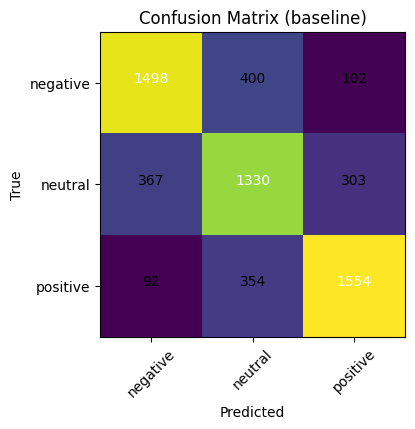

Imagen guardada en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/02_confusion_matrix.png


In [8]:
import itertools

labels = sorted(df[label_col].unique())
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(4.8,4.2))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (baseline)')
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
th = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], ha="center",
             color="white" if cm[i, j] > th else "black")
plt.tight_layout()
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()
# Ruta para guardar la matriz de confusión
cm_path = rutas.get_images_dir() / f"{id_arch}confusion_matrix.png"

# Guardar la figura
save_fig(cm_path)


Guardar artefactos: modelo, config, evaluación y predicciones

In [9]:
#Ruras de salida en donde se guardaran los artefactos
model_path = rutas.get_models_dir() / f"{id_arch}sentiment_logreg_tfidf.joblib"
cfg_path   = rutas.configs_dir / f"{id_arch}sentiment_logreg_tfidf.json"
eval_path  = rutas.get_eval_dir() / f"{id_arch}sentiment_eval.json"
preds_csv  = rutas.get_processed_dir() / f"{id_arch}preds_sentiment.csv"

# Guardar modelo
joblib.dump(pipeline, model_path)
print("Modelo guardado en:", model_path)

# Guardar configuración
config = {
    "model": "logreg_tfidf",
    "tfidf": {"ngram_range": [1,2], "min_df": 2, "max_features": 50000},
    "split": {"test_size": 0.2, "stratify": True, "seed": seed},
    "labels": sorted(df[label_col].unique())
}
save_json(config, cfg_path)
print("Config guardada en:", cfg_path)

# Guardar las métricas
evaluation = {
    "accuracy": float(acc),
    "f1_macro": float(f1m),
    "report": classification_report(y_test, preds, output_dict=True)
}
save_json(evaluation, eval_path)
print("Evaluación guardada en:", eval_path)

# Guardar predicciones
pd.DataFrame({
    "text": X_test.values,
    "y_true": y_test.values,
    "y_pred": preds
}).to_csv(preds_csv, index=False, encoding="utf-8")
print("Predicciones guardadas en:", preds_csv)

Modelo guardado en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/trained_models/02_sentiment_logreg_tfidf.joblib
JSON guardado en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/model_configs/02_sentiment_logreg_tfidf.json
Config guardada en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/model_configs/02_sentiment_logreg_tfidf.json
JSON guardado en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/02_sentiment_eval.json
Evaluación guardada en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/02_sentiment_eval.json
Predicciones guardadas en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/processed/02_preds_sentiment.csv


GridSearch

In [10]:

# Espacio de búsqueda (ajústalo si hace falta)
param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2, 5],
    "tfidf__max_features": [20000, 50000, None],
    "clf__C": [0.1, 0.5, 1.0, 2.0, 10.0],
    "clf__class_weight": [None, "balanced"],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"],
    "clf__max_iter": [1000, 2000],
}

# GridSearchCV
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",            # métrica objetivo
    cv=3,                          # puedes subir a 5 si el tiempo lo permite
    n_jobs=-1,
    refit=True,                    # reentrena el mejor con todo el train
    verbose=2,
    return_train_score=False
)

gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV F1_macro:", gs.best_score_)

# Evaluación en test con el mejor modelo
best_model = gs.best_estimator_
preds = best_model.predict(X_test)
acc  = accuracy_score(y_test, preds)
f1m  = f1_score(y_test, preds, average="macro")
print(f"Test Accuracy: {acc:.4f} | Test F1_macro: {f1m:.4f}")
print(classification_report(y_test, preds))

# Guardar artefactos
MODELS  = rutas.get_models_dir()
CONFIGS = rutas.configs_dir         # atributo del módulo
EVAL    = rutas.get_eval_dir()

model_path     = MODELS  / f"{id_arch}baseline_best.joblib"
params_path    = CONFIGS / f"{id_arch}baseline_gridsearch_params.json"
cvresults_path = EVAL    / f"{id_arch}baseline_gridsearch_results.csv"
test_eval_path = EVAL    / f"{id_arch}baseline_test_eval.json"

# a) Mejor modelo
joblib.dump(best_model, model_path)
# b) Parámetros óptimos
with open(params_path, "w", encoding="utf-8") as f:
    json.dump(gs.best_params_, f, ensure_ascii=False, indent=2)
# c) Resultados completos del grid
pd.DataFrame(gs.cv_results_).to_csv(cvresults_path, index=False, encoding="utf-8")
# d) Métricas en test
with open(test_eval_path, "w", encoding="utf-8") as f:
    json.dump(
        {"accuracy": float(acc), "f1_macro": float(f1m),
         "report": classification_report(y_test, preds, output_dict=True)},
        f, ensure_ascii=False, indent=2
    )

print("Guardado:")
print("  Modelo ->", model_path)
print("  Best params ->", params_path)
print("  CV results ->", cvresults_path)
print("  Test eval ->", test_eval_path)


Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best params: {'clf__C': 10.0, 'clf__class_weight': None, 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best CV F1_macro: 0.735654052085978
Test Accuracy: 0.7507 | Test F1_macro: 0.7516
              precision    recall  f1-score   support

    negative       0.79      0.77      0.78      2000
     neutral       0.66      0.70      0.68      2000
    positive       0.81      0.79      0.80      2000

    accuracy                           0.75      6000
   macro avg       0.75      0.75      0.75      6000
weighted avg       0.75      0.75      0.75      6000

Guardado:
  Modelo -> /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/trained_models/02_baseline_best.joblib
  Best params -> /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/model_configs/02_baseline_gridsearch_params.json
  CV re

Predicciones guardadas en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/02_preds_with_proba.csv


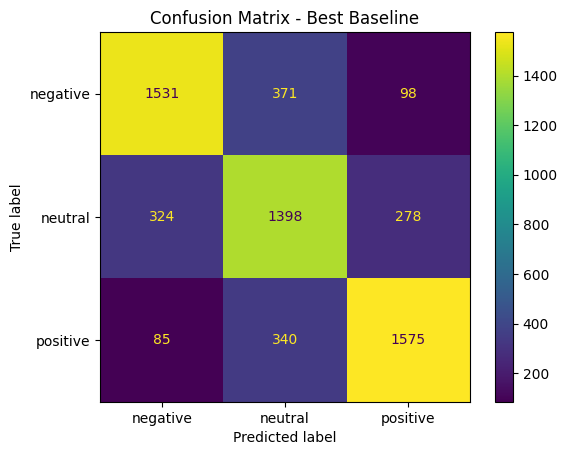

Imagen guardada en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/02_confusion_matrix.png
Classification report guardado en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/02_classification_report.json


In [16]:
# Predicciones con probabilidades + Matriz de confusión (best_model)

EVAL = rutas.get_eval_dir()
IMGS = rutas.get_images_dir()

# Helper para guardar figuras con creación de carpeta
def _save_fig(path):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(path, dpi=160, bbox_inches="tight")
    plt.close()
    print("Figura guardada en:", path)

# Predicciones y probabilidades
y_pred = best_model.predict(X_test)

proba = None
if hasattr(best_model, "predict_proba"):
    proba = best_model.predict_proba(X_test)
elif hasattr(best_model, "named_steps") and hasattr(best_model.named_steps.get("clf", None), "predict_proba"):
    proba = best_model.named_steps["clf"].predict_proba(best_model.named_steps["tfidf"].transform(X_test))

# Construir DataFrame de salida
preds_df = pd.DataFrame({
    "text": np.array(X_test),
    "y_true": np.array(y_test),
    "y_pred": y_pred
})

# Añadir columnas de probabilidad por clase si están disponibles
if proba is not None:
    # clases desde el clasificador del pipeline
    classes = best_model.named_steps["clf"].classes_.tolist()
    for i, c in enumerate(classes):
        preds_df[f"proba_{c}"] = proba[:, i]

# Guardar CSV con predicciones (+ proba si hay)
preds_csv = EVAL / f"{id_arch}preds_with_proba.csv"
preds_df.to_csv(preds_csv, index=False, encoding="utf-8")
print("Predicciones guardadas en:", preds_csv)

# Matriz de confusión (png)
labels = sorted(pd.Series(y_test).unique().tolist())
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title("Confusion Matrix - Best Baseline")
plt.show()
cm_png = IMGS / f"{id_arch}confusion_matrix.png"
save_fig(cm_png)


# Guardar classification_report a JSON (útil para dashboard)
cr_json = EVAL / f"{id_arch}classification_report.json"
with open(cr_json, "w", encoding="utf-8") as f:
    json.dump(classification_report(y_test, y_pred, output_dict=True),
              f, ensure_ascii=False, indent=2)
print("Classification report guardado en:", cr_json)


 ABSA (Aspect-Based) baseline por diccionario + gráfico

ABSA baseline guardado en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/processed/02_absa_baseline.csv


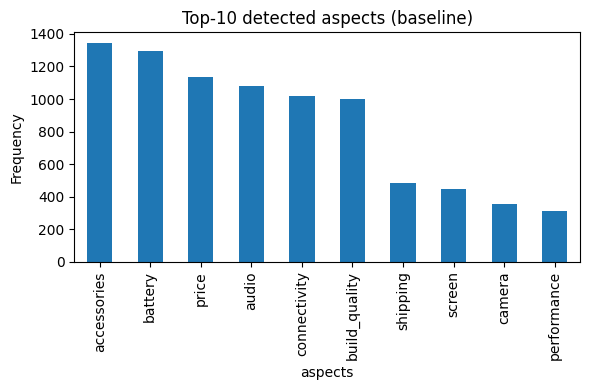

Imagen guardada en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/02_absa_counts.png


In [17]:
#unidecode sirve para quitar acentos y caracteres especiales y convertirlos a caracteres ASCII simples.

import re
try:
    from unidecode import unidecode  # pip install Unidecode (opcional, pero recomendado)
except Exception:
    # fallback simple si no está instalado
    def unidecode(x):
        return x

# Palabras clave por aspecto (ES + EN)
# palabras ocupadas en las reseñas teniendo en cuenta que la base es de reviews de celulares y sus accesorios
words_reviews = {
    "price": [
        "precio","costoso","caro","barato","oferta","descuento",
        "price","cost","expensive","cheap","deal","offer"
    ],
    "battery": [
        "bateria","carga","cargando","duracion","se descarga",
        "battery","charge","charging","battery life","lasts","drain"
    ],
    "screen": [
        "pantalla","brillo","resolucion","oled","amoled","lcd",
        "screen","display","brightness","resolution","oled","amoled","lcd"
    ],
    "camera": [
        "camara","foto","fotos","imagen","video","estabilizacion",
        "camera","photo","picture","video","stabilization","stabilisation"
    ],
    "performance": [
        "rendimiento","lento","rapido","fluido","lag","procesador","chip","ram",
        "performance","slow","fast","snappy","lag","processor","chip","ram"
    ],
    "audio": [
        "sonido","audio","volumen","parlante","bocina","auricular","microfono","mic",
        "sound","audio","volume","speaker","earphone","headphone","microphone","mic"
    ],
    "connectivity": [
        "senal","wifi","bluetooth","5g","lte","datos","red",
        "signal","wifi","bluetooth","5g","lte","data","network"
    ],
    "build_quality": [
        "calidad","material","defecto","defectuoso","fragil","resistente","durable",
        "quality","material","defect","defective","fragile","sturdy","durable"
    ],
    "shipping": [
        "envio","entrega","llego","tarde","paquete","empaque","courier",
        "shipping","delivery","arrived","late","package","packaging","courier"
    ],
    "accessories": [
        "cargador","funda","cable","protector","auriculares","audifonos","earbuds",
        "charger","case","cable","protector","earbuds","headphones"
    ],
}

def detect_aspects_rule(text: str):
    """Detecta aspectos por reglas ES+EN con coincidencia por palabra completa."""
    t = unidecode(str(text).lower())
    found = set()
    for aspect, kws in words_reviews.items():
        for kw in kws:
            pat = rf"\b{re.escape(unidecode(kw.lower()))}\b"
            if re.search(pat, t):
                found.add(aspect)
                break
    return list(found)

# Construir DF ABSA para el test
absa = pd.DataFrame({
    "text": X_test.values,
    "sentiment_pred": preds,
    "aspects": [detect_aspects_rule(t) for t in X_test.values]
})

# Rutas de salida (helpers)
PROC = rutas.get_processed_dir()   # data/processed
IMGS = rutas.get_images_dir()      # docs/images

# Guardar CSV ABSA
absa_csv = PROC / f"{id_arch}absa_baseline.csv"
absa.to_csv(absa_csv, index=False, encoding="utf-8")
print("ABSA baseline guardado en:", absa_csv)

# TOP-10 de aspectos y gráfico
aspect_counts = (
    absa.explode("aspects")
        .dropna()
        .groupby("aspects")
        .size()
        .sort_values(ascending=False)
)
top = aspect_counts.head(10)

plt.figure(figsize=(6,4))
top.plot(kind="bar")
plt.title("Top-10 detected aspects (baseline)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
absa_fig = IMGS / f"{id_arch}absa_counts.png"
save_fig(absa_fig)


Urgencia (baseline EN) + export

In [18]:
from utils import config_rutas as cr  # Importa las rutas del proyecto

# Lista de palabras clave que indican "urgencia" en reseñas (en inglés)
# Puedes adaptarla según tu dominio o idioma
urgency_keys = [
    "complaint", "return", "refund", "doesn't work", "does not work",
    "defective", "warranty", "scam", "broken", "won't charge", "does not charge",
    "fault", "bad", "terrible", "cancel", "missing", "lost", "damage", "damaged"
]

def urgency_score(text: str):
    """
    Calcula un puntaje de urgencia en el rango [0, 1] para un texto.
    """
#  - Convierte a minúsculas para búsqueda insensible a mayúsculas.
#  - Suma 0.2 por cada palabra clave encontrada.
#  - El puntaje base mínimo es 0.2.
#  - El valor máximo está limitado a 1.0.
    t = str(text).lower()  # Texto en minúsculas
    base = 0.2             # Puntaje inicial (aunque no haya palabras clave)
    hits = sum(1 for k in urgency_keys if k in t)  # Cantidad de coincidencias
    return float(min(1.0, base + 0.2 * hits))      # Puntaje final limitado a 1.0

# Crear un DataFrame con:
# - Texto original (test set)
# - Predicción de sentimiento
# - Puntaje de urgencia calculado
urg = pd.DataFrame({
    "text": X_test.values,
    "sentiment_pred": preds,
    "urgency": [urgency_score(t) for t in X_test.values]
})

# Ruta para guardar el CSV de urgencia baseline en /data/processed/
urg_csv = cr.get_processed_dir() / f"{id_arch}urgency_baseline.csv"
urg.to_csv(urg_csv, index=False, encoding="utf-8")
print("Urgency baseline guardado en:", urg_csv)

# Ordenar por urgencia y quedarse con los 10 casos más urgentes
urgent_top = urg.sort_values("urgency", ascending=False).head(10)

# Ruta para guardar el CSV del Top-10 en /notebooks/evaluation/
urgent_top10_csv = cr.get_eval_dir() / f"{id_arch}urgent_top.csv"
urgent_top.to_csv(urgent_top10_csv, index=False, encoding="utf-8")
print("Top-10 urgencias guardado en:", urgent_top10_csv)

# Mostrar en pantalla el Top-10
urgent_top


Urgency baseline guardado en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/processed/02_urgency_baseline.csv
Top-10 urgencias guardado en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/02_urgent_top.csv


,text,sentiment_pred,urgency
1248,In December 2007 I renewed my AT&T contract an...,negative,1.0
2103,"Like so many others, I am on a perpeptual sear...",neutral,1.0
2601,I've purchased two of these phones but I didn'...,positive,1.0
2653,Ordered this 'charging kit' for my Tungsten E2...,negative,1.0
206,UPDATED Feb 9th 2008: Well the BT5020 is now d...,neutral,1.0
3000,"I own two different Motorola Headsets, and wit...",negative,1.0
5470,"I tried. I really, really tried. But this syst...",negative,1.0
3360,The product did not work for me. For some reas...,negative,1.0
5823,"I bought this Sept 8, 2016 and it was great! I...",negative,1.0
3540,I bought those to replace my LG HBS-730 after ...,negative,1.0


Cargar el modelo guardado y hacer inferencia rápida (EN)

In [23]:
#Ruras de salida en donde se guardaran los artefactos
MODELS = rutas.get_models_dir()   # .../models/trained_models
EVAL   = rutas.get_eval_dir()     # .../data/evaluation

# Se carga el pipeline (TF-IDF + Regresión Logística) guardado previamente
# desde la carpeta /models/trained_models/
model_path = MODELS / f"{id_arch}sentiment_logreg_tfidf.joblib"
loaded = joblib.load(model_path)
print("Modelo cargado desde:", model_path)

def predict_texts(texts):
    """
    Devuelve la etiqueta de sentimiento ('positive'/'neutral'/'negative')
    para cada texto usando el modelo cargado.
    """
    return loaded.predict(texts)

# --- 2) Prueba rápida de inferencia ---
examples = [
    "Great camera and battery life, totally recommended.",
    "Arrived late and the charger doesn't work. Terrible.",
    "Fair price, decent screen, nothing extraordinary."
]

preds_demo = list(zip(examples, predict_texts(examples)))
for text, pred in preds_demo:
    print(f"[{pred.upper()}] {text}")

# --- 3) Guardar resultados de la prueba ---
demo_csv = EVAL / "sample_inference.csv"   # nombre libre; cámbialo si quieres
pd.DataFrame(preds_demo, columns=["text", "prediction"]).to_csv(
    demo_csv, index=False, encoding="utf-8"
)
print("Inferencias de ejemplo guardadas en:", demo_csv)


Modelo cargado desde: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/trained_models/02_sentiment_logreg_tfidf.joblib
[POSITIVE] Great camera and battery life, totally recommended.
[NEGATIVE] Arrived late and the charger doesn't work. Terrible.
[NEUTRAL] Fair price, decent screen, nothing extraordinary.
Inferencias de ejemplo guardadas en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/sample_inference.csv


Simulacion tiempo real

In [26]:
#Rutas de salida
EVAL   = rutas.get_eval_dir()
MODELS = rutas.get_models_dir()
out_csv = EVAL / f"{id_arch}realtime_events.csv"

#Asegurar modelo listo (usa el que tengas: best o entrenado base o 'pipeline' en RAM)
best_model = globals().get("best_model")
if best_model is None:
    # intenta cargar desde disco (best -> base). Si no, intenta 'pipeline' ya entrenado en RAM.
    candidates = [
        MODELS / f"{id_arch}baseline_best.joblib",
        MODELS / f"{id_arch}sentiment_logreg_tfidf.joblib",
    ]
    loaded = None
    for p in candidates:
        if Path(p).exists():
            loaded = joblib.load(p)
            print("Modelo cargado desde:", p)
            break
    if loaded is None:
        # fallback: si tienes 'pipeline' en memoria
        loaded = globals().get("pipeline")
        if loaded is not None:
            print("Usando 'pipeline' en memoria como modelo.")
        else:
            raise RuntimeError("No encontré modelo. Entrena o guarda el baseline antes de correr tiempo real.")
    best_model = loaded

#Fallbacks por si no definiste urgencia o respuesta en el notebook ---
def _fallback_urgency_score(text: str) -> float:
    keys = ["complaint","return","refund","broken","defective","warranty",
            "late","missing","lost","damage","damaged","won't charge","does not work"]
    t = str(text).lower()
    base = 0.2
    hits = sum(1 for k in keys if k in t)
    return float(min(1.0, base + 0.2 * hits))

def _fallback_reply_es(sentiment, aspects, u):
    def lvl(x): return "alta" if x >= 0.8 else "media" if x >= 0.5 else "baja"
    ax = ", ".join(aspects) if aspects else "el producto"
    ustr = lvl(u)
    if sentiment == "negative":
        if ustr == "alta":
            return (f"Lamentamos lo ocurrido con {ax}. Escalamos tu caso para atención prioritaria. "
                    "Por favor envía tu número de pedido para resolverlo cuanto antes.")
        if ustr == "media":
            return (f"Gracias por avisarnos sobre {ax}. ¿Puedes compartir más detalles o una foto del problema?")
        return f"Lamentamos tu experiencia con {ax}. Tomamos nota para mejorar."
    if sentiment == "positive":
        return f"¡Gracias! Nos alegra tu buena experiencia con {ax}."
    return f"Gracias por tu comentario sobre {ax}. Si necesitas ayuda, estamos atentos."

# Si en tu notebook ya existen estas funciones, se usarán; si no, usamos los fallbacks.
urgency_score_fn   = globals().get("urgency_score", _fallback_urgency_score)
generate_reply_fn  = globals().get("generate_reply_es", _fallback_reply_es)

#Función que procesa un evento (un texto)
def process_event(text: str) -> dict:
    s = best_model.predict([text])[0]        # sentimiento
    aspects = detect_aspects_rule(text)      # aspectos (tu regla)
    u = float(urgency_score_fn(text))        # urgencia [0..1]
    reply = generate_reply_fn(s, aspects, u) if generate_reply_fn is _fallback_reply_es else generate_reply_fn(text, s, aspects, u)
    return {"text": text, "sentiment": s, "aspects": aspects, "urgency_score": u, "reply": reply}

#  Simulador de streaming: pasa una lista de textos o lee un CSV incremental ---
def run_stream(text_iterable, sleep_s=0.2, save_every=5):
    """
    Procesa textos uno a uno e imprime resultados; guarda acumulado en CSV.
    - text_iterable: iterable de strings (p.ej. lista, generator)
    - sleep_s: retardo entre eventos para simular llegada gradual
    - save_every: cada N eventos, escribe CSV
    """
    events = []
    count = 0
    for t in text_iterable:
        out = process_event(t)
        events.append(out)
        count += 1
        print(f"[{out['sentiment'].upper()} | urg={out['urgency_score']:.2f}] {t}")
        print("→", out["reply"])
        print("-"*60)
        if count % save_every == 0:
            pd.DataFrame(events).to_csv(out_csv, index=False, encoding="utf-8")
        time.sleep(sleep_s)
    pd.DataFrame(events).to_csv(out_csv, index=False, encoding="utf-8")
    print("Eventos exportados a:", out_csv)

# EJEMPLO rápido de uso (puedes reemplazar por una review real / lectura de archivo) ---
queue_texts = [
    "La batería se descarga muy rápido y el cargador no funciona.",
    "Llegó a tiempo y la cámara es excelente.",
    "La pantalla está bien, pero el precio me pareció alto.",
    "Refund requested, item arrived damaged and the box was open.",
]
run_stream(queue_texts, sleep_s=0.15, save_every=2)


[POSITIVE | urg=0.20] La batería se descarga muy rápido y el cargador no funciona.
→ ¡Gracias! Nos alegra tu buena experiencia con battery, accessories.
------------------------------------------------------------
[POSITIVE | urg=0.20] Llegó a tiempo y la cámara es excelente.
→ ¡Gracias! Nos alegra tu buena experiencia con el producto.
------------------------------------------------------------
[NEUTRAL | urg=0.20] La pantalla está bien, pero el precio me pareció alto.
→ Gracias por tu comentario sobre price, screen. Si necesitas ayuda, estamos atentos.
------------------------------------------------------------
[NEGATIVE | urg=0.80] Refund requested, item arrived damaged and the box was open.
→ Lamentamos lo ocurrido con shipping. Escalamos tu caso para atención prioritaria. Por favor envía tu número de pedido para resolverlo cuanto antes.
------------------------------------------------------------
Eventos exportados a: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/da

#Conclusiones – Notebook 02_Modelo_Baseline

* **Implementación y objetivo del modelo**  
   - Se construyó un **modelo base (baseline)** para establecer un punto de referencia inicial en la tarea de análisis de sentimientos.  

* **Resultados clave**  
   - El modelo alcanzó una precisión global (accuracy) del 75% y un F1-macro de 0.7516, lo que indica un rendimiento equilibrado en las tres clases de sentimiento (positivo, negativo y neutral).
   - Negativo: Precisión 0.79, Recall 0.77, F1-score 0.78
   -Neutral: Precisión 0.66, Recall 0.68, F1-score 0.67
   -Positivo: Precisión 0.81, Recall 0.79, F1-score 0.80
* La integración del procesamiento en tiempo  real posibilita analizar y clasificar reseñas inmediatamente después de su recepción, mejorando la capacidad de respuesta de la organización ante problemas críticos. Esto, combinado con la clasificación de urgencia, facilita la priorización de casos que requieren atención inmediata.